# Exploring the differences between the vz and vb AVRs

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [131]:
gaia_mc = pd.read_csv("gaia_mc.csv")
print(np.shape(gaia_mc))

# Cut out visual binaries.
gaia_mc = gaia_mc.iloc[gaia_mc.flag.values == 1]
print(np.shape(gaia_mc), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc.vb_err.values < 1.
print(np.shape(gaia_mc.iloc[m]), "no large vb uncertainties")

m &= gaia_mc.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc.age.values > .5
print(np.shape(gaia_mc.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars
m &= (gaia_mc.color_teffs.values < 5000) * (3500 < gaia_mc.color_teffs.values)
print(np.shape(gaia_mc.iloc[m]), "no hot or cold stars")

gaia_mc = gaia_mc.iloc[m]

(29727, 156)
(10674, 156) no visual binaries or subgiants
(10533, 156) no large vb uncertainties
(10394, 156) no faint stars
(9791, 156) no rapid rotators
(6925, 156) no hot or cold stars


298 stars with vz out of 6925 stars


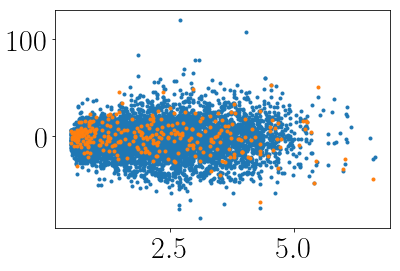

In [132]:
plt.plot(gaia_mc.age, gaia_mc.vb, ".")
plt.plot(gaia_mc.age, gaia_mc.vz, ".")
print(len(gaia_mc.vz.values[np.isfinite(gaia_mc.vz.values)]), "stars with vz out of", len(gaia_mc), "stars")

Calculate both vb and vz velocity dispersion as a function of age and see if the exponents are the same.

In [133]:
age_bins = 10**np.linspace(np.log10(.5), np.log10(7), 11)

In [134]:
age_masks = select_stars(gaia_mc, age_bins, "age")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


417 26
682 34
565 26
707 26
864 23
1123 44
1201 42
940 45
401 26
25 6


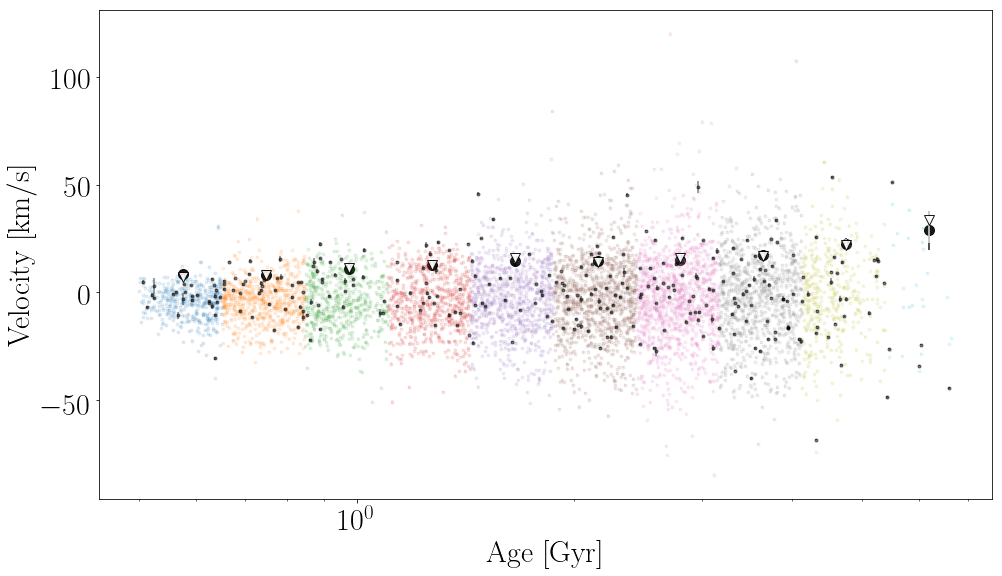

In [135]:
plt.figure(figsize=(16, 9))

dz, dzerr, db, dberr, db_all, dberr_all, err_on_mean_b, err_on_mean_z = \
    [np.zeros(len(age_bins)) for i in range(8)]
for i, m in enumerate(age_masks):
    
    # Only pick stars which have vz values, so you're comparing apples to apples.
    f = np.isfinite(gaia_mc.vz.values[m])

    plt.errorbar(gaia_mc.age[m], gaia_mc.vb[m], yerr=gaia_mc.vb_err[m], fmt=".", alpha=.1)
    db[i], dberr[i] = calc_dispersion_and_dispersion_err(gaia_mc.vb[m][f], gaia_mc.vb_err[m][f], 10000)
    
    db_all[i], dberr_all[i] = calc_dispersion_and_dispersion_err(gaia_mc.vb[m], gaia_mc.vb_err[m], 10000)
    
    plt.errorbar(gaia_mc.age[m][f], gaia_mc.vz[m][f], yerr=gaia_mc.vz_err[m][f], fmt="k.", alpha=.5)
    dz[i], dzerr[i] = calc_dispersion_and_dispersion_err(gaia_mc.vz[m][f], gaia_mc.vz_err[m][f], 10000)
    print(sum(m), len(gaia_mc.age[m][f]))
    
    err_on_mean_b[i] = err_on_sample_std_dev(db[i], len(gaia_mc.age[m][f])) #db[i]/np.sqrt(len(gaia_mc.age[m][f]))
    err_on_mean_z[i] = err_on_sample_std_dev(dz[i], len(gaia_mc.age[m][f])) #dz[i]/np.sqrt(len(gaia_mc.age[m][f]))
#     err_on_mean_b[i] = err_on_sample_std_dev(np.median(gaia_mc.vb_err[m][f]), len(gaia_mc.age[m][f]))
#     err_on_mean_z[i] = err_on_sample_std_dev(np.median(gaia_mc.vz_err[m][f]), len(gaia_mc.age[m][f]))
    
mid_age_bins = age_bins[:-1] + np.diff(age_bins)*.5
plt.errorbar(mid_age_bins, db[:-1], yerr=err_on_mean_b[:-1],
             fmt="o", color="k", alpha=.9, zorder=1, ms=10, label="$\mathrm{\sigma_{vb}}$")
plt.errorbar(mid_age_bins, dz[:-1], yerr=err_on_mean_z[:-1],
             fmt="v", color="w", alpha=.9, zorder=2, mec="k", ms=10, label="$\mathrm{\sigma_{vz}}$")

plt.xscale("log")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Velocity~[km/s]}$");

In [136]:
print(db)
print(dberr)
print(err_on_mean_b)
print(dz, dzerr)

[ 8.46374955  8.2733147  11.0540949  12.95025784 14.37209473 14.38417872
 14.8922208  17.52135273 22.26415622 28.75965502  0.        ]
[0.01212762 0.00876549 0.01308329 0.01200488 0.01552043 0.01403404
 0.01736282 0.01438035 0.03489909 0.05594272 0.        ]
[1.19695494 1.01837464 1.56328509 1.83144303 2.1666748  1.55108588
 1.64457067 1.86778248 3.14862717 9.09460146 0.        ]
[ 7.06533394  8.003312   11.23520136 12.78022341 16.18373957 14.22987774
 15.97504656 16.90399485 21.79334612 33.41557088  0.        ] [0.17313068 0.14577724 0.15558104 0.14262692 0.10909652 0.09079683
 0.23423843 0.08017127 0.08369499 0.17911247 0.        ]


Linear least squares line fit.

Plot velocity dispersion (vb) as a function of age. Don't include the last bin because there are almost no stars in it.

<ErrorbarContainer object of 3 artists>

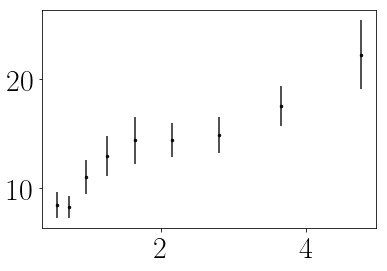

In [137]:
plt.errorbar(mid_age_bins[:-1], db[:-2], yerr=err_on_mean_b[:-2],
             fmt=".", color="k", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vb}}$")

AVR vb exponent = 0.42 +- 0.06


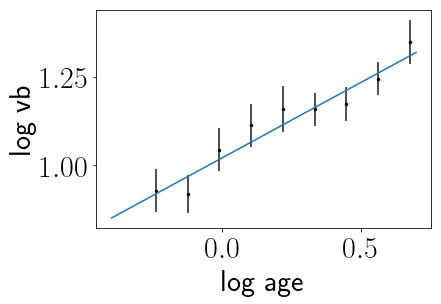

In [138]:
yerrb = err_to_log10_err(db[:-2], err_on_mean_b[:-2])
plt.errorbar(np.log10(mid_age_bins[:-1]), np.log10(db[:-2]), yerr=yerrb,
             fmt=".", color="k", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vb}}$")
plt.ylabel("log vb")
plt.xlabel("log age")

w, wcovar = fit_line(np.log10(mid_age_bins[:-1]), np.log10(db[:-2]), yerrb)
w0_err = np.sqrt(wcovar[0, 0])
w1_err = np.sqrt(wcovar[1, 1])
xs = np.linspace(-.4, .7, 100)
plt.plot(xs, w[0] + w[1]*xs)

print("AVR vb exponent = {0:.2f} +- {1:.2f}".format(w[1], np.sqrt(wcovar[1, 1])))

Plot velocity dispersion (vz) as a function of age.

AVR vz exponent = 0.47 +- 0.06


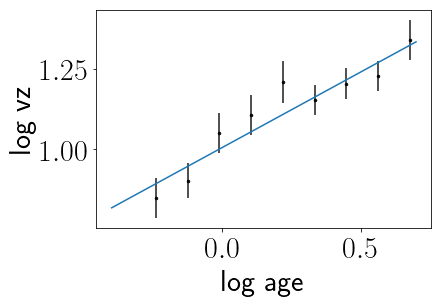

In [139]:
yerrz = err_to_log10_err(dz[:-2], err_on_mean_z[:-2])
plt.errorbar(np.log10(mid_age_bins[:-1]), np.log10(dz[:-2]), yerr=yerrz,
             fmt=".", color="k", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vz}}$")

# plt.errorbar(mid_age_bins[:-1], dz[:-2], yerr=dzerr[:-2],
#              fmt=".", color="k", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vz}}$")

plt.ylabel("log vz")
plt.xlabel("log age")

w, wcovar = fit_line(np.log10(mid_age_bins[:-1]), np.log10(dz[:-2]), yerrz)
xs = np.linspace(-.4, .7, 100)
plt.plot(xs, w[0] + w[1]*xs)

print("AVR vz exponent = {0:.2f} +- {1:.2f}".format(w[1], np.sqrt(wcovar[1, 1])))

In [140]:
print(mid_age_bins)
print(age_bins)

[0.57550136 0.74930591 0.97560039 1.27023703 1.65385554 2.15332893
 2.80364601 3.6503624  4.75279175 6.18816078]
[0.5        0.65100273 0.8476091  1.10359167 1.43688238 1.87082869
 2.43582916 3.17146286 4.12926194 5.37632156 7.        ]


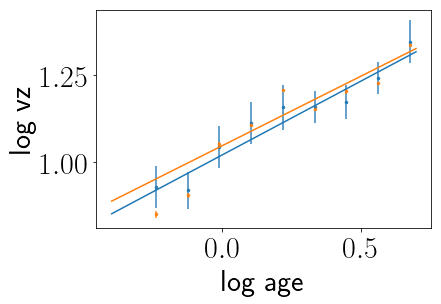

In [141]:
plt.errorbar(np.log10(mid_age_bins[:-1]), np.log10(db[:-2]), yerr=yerrb,
             fmt=".", color="C0", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vb}}$")
plt.ylabel("log vb")
plt.xlabel("log age")

w, wcovar = fit_line(np.log10(mid_age_bins[:-1]), np.log10(db[:-2]), yerrz)
xs = np.linspace(-.4, .7, 100)
plt.plot(xs, w[0] + w[1]*xs, "C0")


plt.errorbar(np.log10(mid_age_bins[:-1]), np.log10(dz[:-2]), yerr=dzerr[:-2]/dz[:-2]*.434,
             fmt=".", color="C1", alpha=.9, zorder=1, ms=5, label="$\mathrm{\sigma_{vz}}$")

plt.ylabel("log vz")
plt.xlabel("log age")

w, wcovar = fit_line(np.log10(mid_age_bins[:-1]), np.log10(dz[:-2]), dzerr[:-2]/dz[:-2]*.434)
xs = np.linspace(-.4, .7, 100)
plt.plot(xs, w[0] + w[1]*xs, "C1")

center =  290.9424547187607 44.38821699840653
highest b =  [280.09994202] [47.59398358] 21.44372242952584
min b =  [299.83959036] [40.54640482] 5.676795501481682
max b =  288.1408942567735 44.1130206875733 14.996150771151788
mid b =  294.9670592418719 42.74086024652517 10


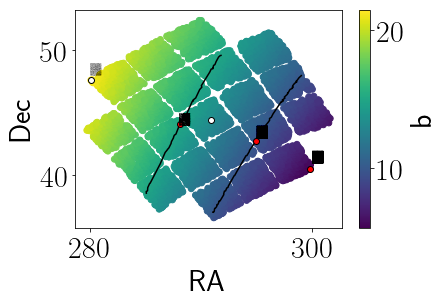

In [142]:
plt.scatter(gaia_mc.ra, gaia_mc.dec, c=gaia_mc.b)
plt.colorbar(label="b")
plt.plot(np.median(gaia_mc.ra), np.median(gaia_mc.dec), "wo", mec="k")
print("center = ", np.median(gaia_mc.ra), np.median(gaia_mc.dec))

plt.xlabel("RA")
plt.ylabel("Dec")

max_b = gaia_mc.b.values == max(gaia_mc.b.values)
min_b = gaia_mc.b.values == min(gaia_mc.b.values)

# Find a pointing at b = 15
m = gaia_mc.b.values < 15
gaia_mc_15 = gaia_mc.iloc[m]
b15 = (14.9 < gaia_mc_15.b.values) * (gaia_mc_15.b.values < 15)

plt.plot(gaia_mc.ra.values[max_b], gaia_mc.dec.values[max_b], "wo", mec="k")
plt.plot(gaia_mc.ra.values[min_b], gaia_mc.dec.values[min_b], "ro", mec="k")
plt.plot(gaia_mc_15.ra.values[b15], gaia_mc_15.dec.values[b15], "k")

print("highest b = ", gaia_mc.ra.values[max_b], gaia_mc.dec.values[max_b], max(gaia_mc.b))

print("min b = ", gaia_mc.ra.values[min_b], gaia_mc.dec.values[min_b], min(gaia_mc.b))

def find_closest(array, x):
    return np.argmin(abs(array - x))

maxb, minb = max(gaia_mc_15.dec.values[b15]), min(gaia_mc_15.dec.values[b15])
ind = find_closest(gaia_mc_15.dec.values[b15], maxb - (maxb - minb)/2)

# plt.plot(gaia_mc_15.ra.values[b15][ind], np.median(gaia_mc.dec), "wo", mec="k")
plt.plot(gaia_mc_15.ra.values[b15][ind], gaia_mc_15.dec.values[b15][ind], "ro", mec="k")
print("max b = ", gaia_mc_15.ra.values[b15][ind], gaia_mc_15.dec.values[b15][ind], max(gaia_mc_15.b))

b15 = (14.9 < gaia_mc_15.b.values) * (gaia_mc_15.b.values < 15)

# Find a pointing at b = 10
b10 = (9.9 < gaia_mc.b.values) * (gaia_mc.b.values < 10)
plt.plot(gaia_mc.ra.values[b10], gaia_mc.dec.values[b10], "k")

maxb10, minb10 = max(gaia_mc.dec.values[b10]), min(gaia_mc.dec.values[b10])
ind = find_closest(gaia_mc.dec.values[b10], maxb10 - (maxb10 - minb10)/2)
plt.plot(gaia_mc.ra.values[b10][ind], gaia_mc.dec.values[b10][ind], "ro", mec="k")
print("mid b = ", gaia_mc.ra.values[b10][ind], gaia_mc.dec.values[b10][ind], 10)

# Load the GUMS sample

low_b = pd.read_csv("min_b.csv", skiprows=68, delimiter=";")
mid_b = pd.read_csv("mid_b.csv", skiprows=68, delimiter=";")
max_b = pd.read_csv("max_b.csv", skiprows=68, delimiter=";")
high_b = pd.read_csv("high_b.csv", skiprows=68, delimiter=";")

plt.plot(low_b.RAJ2000, low_b.DEJ2000, "k.", ms=.1, alpha=.02)
plt.plot(mid_b.RAJ2000, mid_b.DEJ2000, "k.", ms=.1, alpha=.02)
plt.plot(max_b.RAJ2000, max_b.DEJ2000, "k.", ms=.1, alpha=.02)
plt.plot(high_b.RAJ2000, high_b.DEJ2000, "k.", ms=.1, alpha=.02)

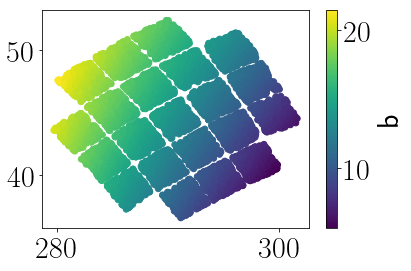

In [174]:
plt.scatter(gaia_mc.ra, gaia_mc.dec, c=gaia_mc.b)
plt.colorbar(label="b")

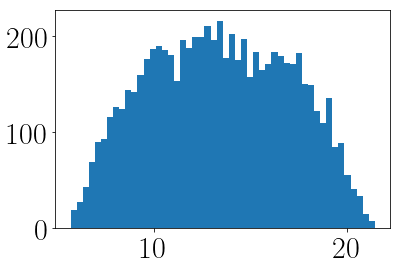

In [143]:
plt.hist(gaia_mc.b, 50);

Load the GUMS catalog of stars at the lowest b in Kepler.

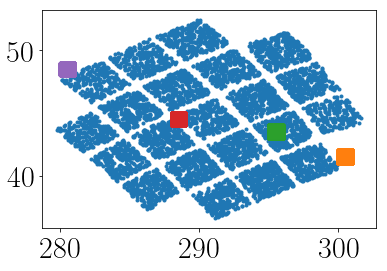

In [144]:
plt.plot(gaia_mc.ra, gaia_mc.dec, ".")
plt.plot(low_b.RAJ2000, low_b.DEJ2000, ".")
plt.plot(mid_b.RAJ2000, mid_b.DEJ2000, ".")
plt.plot(max_b.RAJ2000, max_b.DEJ2000, ".")
plt.plot(high_b.RAJ2000, high_b.DEJ2000, ".")

In [145]:
low_b.head()

,Pop,Gmag,GBmag,GRmag,Gsmag,RAJ2000,DEJ2000,r,pmRA,pmDE,RV,Mass,[Fe/H],Teff,logg,fI,Vtype
0,1,17.518,18.020,16.832,16.527,300.234818,41.009998,6876.5,-3.649,-3.980,-85.9,1.59,0.00,6166,3.79,0,NaN
1,1,18.890,19.871,17.854,17.383,300.241065,41.003657,1588.2,0.669,-0.552,-31.7,1.18,-0.11,0,0.00,0,NaN
2,1,19.126,20.059,18.117,17.661,300.241079,41.003710,1588.2,0.669,-0.552,-31.2,0.67,-0.11,4130,4.66,0,NaN
3,1,20.663,21.864,19.517,18.990,300.241046,41.003588,1588.2,0.669,-0.552,-31.8,0.51,-0.11,3698,4.77,0,NaN
4,1,19.101,19.849,18.213,17.815,300.234334,41.004235,3555.6,-1.214,-3.293,-30.5,1.62,0.00,0,0.00,0,NaN


In [146]:
import astropy.coordinates as coord
import astropy.units as u

def calc_vb_vz(df):

    sim_c_minb = coord.SkyCoord(ra=df.RAJ2000.values*u.deg,
                            dec=df.DEJ2000.values*u.deg,
                            distance=df.r.values*u.pc,
                            pm_ra_cosdec=df.pmRA.values*u.mas/u.yr,
                            pm_dec=df.pmDE.values*u.mas/u.yr,
                            radial_velocity=df.RV.values*u.km/u.s)

    gal = sim_c_minb.galactic
    galcen = sim_c_minb.transform_to(coord.Galactocentric)
    l, b = gal.l.degree, gal.b.degree

    vb = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles())
    vz = galcen.v_z
    return vb, vz, l, b

def calc_lb(ra, dec):
    c = coord.SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    gal = c.galactic
    return gal.l.degree, gal.b.degree

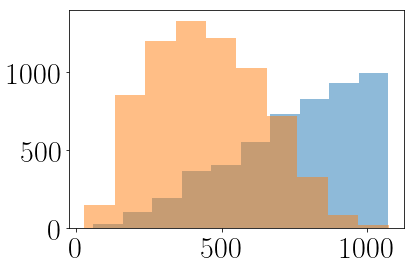

In [147]:
m = low_b.r.values < max(1./gaia_mc.parallax.values*1e3)
plt.hist(low_b.r.iloc[m], alpha=.5);
plt.hist(1./gaia_mc.parallax.values*1e3, alpha=.5);

In [148]:
m = (low_b.Gmag.values < 16) * (low_b.r.values < max(1./gaia_mc.parallax.values*1e3)) \
    * (low_b.Teff.values < 6000) * (low_b.Teff.values > 0)
df1 = low_b.iloc[m]
vb, vz, l, b = calc_vb_vz(df1)

# fig = plt.figure(figsize=(16, 9), dpi=200)
# plt.scatter(vb, vb - vz, c=b, edgecolor="none", alpha=0.3)
# cb = plt.colorbar(label="b")
# cb.solids.set_alpha(1)
# plt.xlabel("Vb")
# plt.ylabel("Vb - Vz")

In [149]:
m = (mid_b.Gmag.values < 16) * (mid_b.r.values < max(1./gaia_mc.parallax.values*1e3)) \
    * (mid_b.Teff.values < 6000) * (mid_b.Teff.values > 0)
df2 = mid_b.iloc[m]
vb, vz, l, b = calc_vb_vz(df2)

# fig = plt.figure(figsize=(16, 9), dpi=200)
# plt.scatter(vb, vb - vz, c=b, edgecolor="none", alpha=0.3)
# cb = plt.colorbar(label="b")
# cb.solids.set_alpha(1)
# plt.xlabel("Vb")
# plt.ylabel("Vb - Vz")

In [150]:
m = (max_b.Gmag.values < 16) * (max_b.r.values < max(1./gaia_mc.parallax.values*1e3)) \
    * (max_b.Teff.values < 6000) * (max_b.Teff.values > 0)
df3 = max_b.iloc[m]
vb, vz, l, b = calc_vb_vz(df3)

# fig = plt.figure(figsize=(16, 9), dpi=200)
# plt.scatter(vb, vb - vz, c=b, edgecolor="none", alpha=0.3)
# plt.colorbar(label="b")
# plt.xlabel("Vb")
# plt.ylabel("Vb - Vz")

In [151]:
m = (high_b.Gmag.values < 16) * (high_b.r.values < max(1./gaia_mc.parallax.values*1e3)) \
    * (high_b.Teff.values < 6000) * (high_b.Teff.values > 0)
df4 = high_b.iloc[m]
vb, vz, l, b = calc_vb_vz(df4)

In [166]:
df = pd.concat([df1, df2])
vb, vz, l, b = calc_vb_vz(df)

# fig = plt.figure(figsize=(16, 9), dpi=200)
# x = np.linspace(-100, 100, 100)
# # plt.plot(x, x, "k--", zorder=0)
# plt.scatter(vb, vb - vz, c=b, edgecolor="none", s=50, alpha=0.2, zorder=1, cmap="viridis", vmin=3, vmax=18)
# cb = plt.colorbar(label="b")
# cb.solids.set_alpha(1)
# plt.xlabel("Vb")
# plt.ylabel("Vb - Vz")
# plt.xlim(-50, 50)
# plt.ylim(-50, 50)


4.556308284468278 km / s


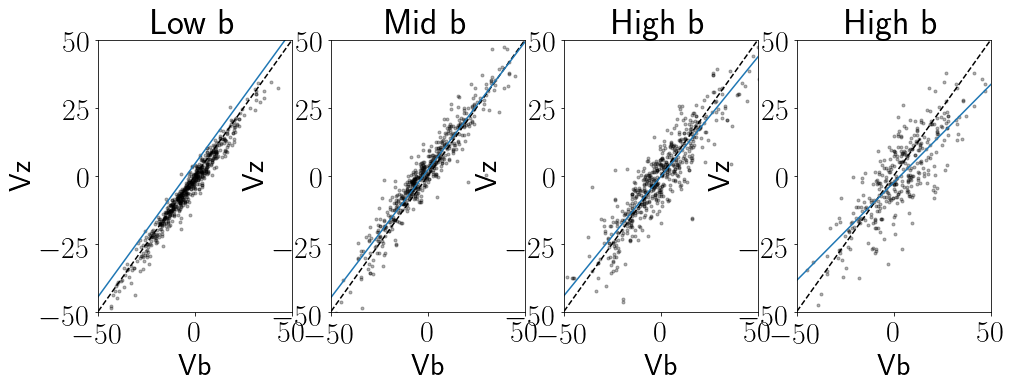

In [167]:
vb, vz, l, b = calc_vb_vz(df1)

x = np.linspace(-100, 100, 100)

plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
plt.plot(x, x, "k--", zorder=0)
plt.plot(vb, vz, "k.", alpha=.3)
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title("Low b")
p = np.polyfit(vb, vz, 1)
plt.plot(x, np.polyval(p, x))
print(np.mean(vz-vb)/np.cos(0.0872665))

vb, vz, l, b = calc_vb_vz(df2)
plt.subplot(1, 4, 2)
plt.plot(x, x, "k--", zorder=0)
plt.plot(vb, vz, "k.", alpha=.3)
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title("Mid b")
p = np.polyfit(vb, vz, 1)
plt.plot(x, np.polyval(p, x))

vb, vz, l, b = calc_vb_vz(df3)
plt.subplot(1, 4, 3)
plt.plot(x, x, "k--", zorder=0)
plt.plot(vb, vz, "k.", alpha=.3)
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title("High b")
p = np.polyfit(vb, vz, 1)
plt.plot(x, np.polyval(p, x))

vb, vz, l, b = calc_vb_vz(df4)
plt.subplot(1, 4, 4)
plt.plot(x, x, "k--", zorder=0)
plt.plot(vb, vz, "k.", alpha=.3)
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title("High b")
p = np.polyfit(vb, vz, 1)
plt.plot(x, np.polyval(p, x))

Download more fields and look at the scatter as a function of b. Select a cut off where the scatter in the vb-vz approximation is less than the velocity dispersion from heating.

Just look at the scatter in the residuals and report the "noise".

2.9095741396579116 2.591652818947794 km/s
5.356577554954921 4.0369326393889855 km/s
7.01681893260408 6.340159746096708 km/s
9.435207565446078 8.713449571769473 km/s


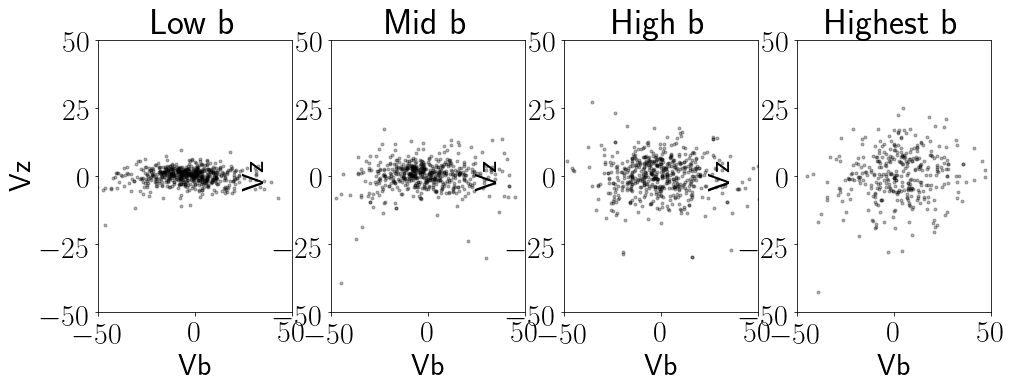

In [183]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
vb, vz, l, b = calc_vb_vz(df1)
p = np.polyfit(vb, vz, 1)
plt.plot(vb, vz.value - np.polyval(p, vb), "k.", alpha=.3)
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title("Low b")
resids = vz.value - np.polyval(p, vb)
print(np.std(resids), 1.5*np.median(np.abs(resids)), "km/s")

vb, vz, l, b = calc_vb_vz(df2)
plt.subplot(1, 4, 2)
p = np.polyfit(vb, vz, 1)
plt.plot(vb, vz.value - np.polyval(p, vb), "k.", alpha=.3)
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title("Mid b")
resids = vz.value - np.polyval(p, vb)
print(np.std(resids), 1.5*np.median(np.abs(resids)), "km/s")

vb, vz, l, b = calc_vb_vz(df3)
plt.subplot(1, 4, 3)
p = np.polyfit(vb, vz, 1)
plt.plot(vb, vz.value - np.polyval(p, vb), "k.", alpha=.3)
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title("High b")
resids = vz.value - np.polyval(p, vb)
print(np.std(resids), 1.5*np.median(np.abs(resids)), "km/s")

vb, vz, l, b = calc_vb_vz(df4)
plt.subplot(1, 4, 4)
p = np.polyfit(vb, vz, 1)
plt.plot(vb, vz.value - np.polyval(p, vb), "k.", alpha=.3)
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title("Highest b")
resids = vz.value - np.polyval(p, vb)
print(np.std(resids), 1.5*np.median(np.abs(resids)), "km/s")

KurtosistestResult(statistic=7.116581030464176, pvalue=1.1063714338167423e-12)
KurtosistestResult(statistic=9.819779836430587, pvalue=9.254544092996512e-23)
KurtosistestResult(statistic=5.503421118558429, pvalue=3.724912329217318e-08)
KurtosistestResult(statistic=3.7828753539960855, pvalue=0.00015502705836272876)


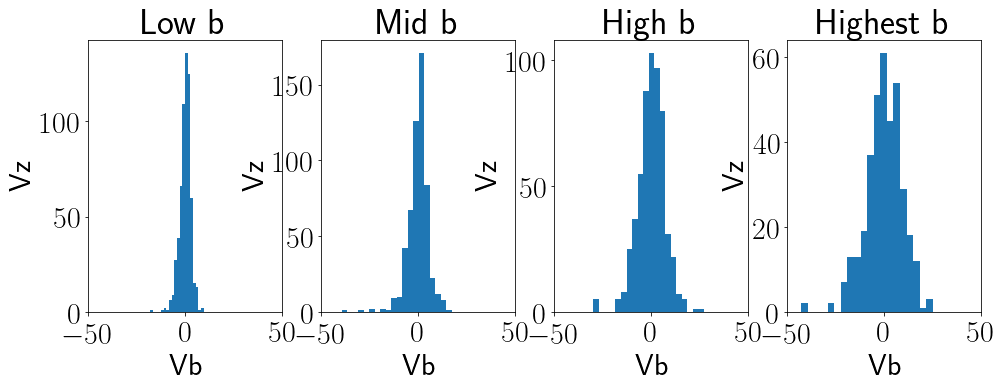

In [193]:
import scipy.stats as sps

plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
vb, vz, l, b = calc_vb_vz(df1)
p = np.polyfit(vb, vz, 1)
plt.hist(vz.value - np.polyval(p, vb), 20);
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.title("Low b")
print(sps.kurtosistest(vz.value - np.polyval(p, vb)))

vb, vz, l, b = calc_vb_vz(df2)
plt.subplot(1, 4, 2)
p = np.polyfit(vb, vz, 1)
plt.hist(vz.value - np.polyval(p, vb), 20);
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.title("Mid b")
print(sps.kurtosistest(vz.value - np.polyval(p, vb)))

vb, vz, l, b = calc_vb_vz(df3)
plt.subplot(1, 4, 3)
p = np.polyfit(vb, vz, 1)
plt.hist(vz.value - np.polyval(p, vb), 20);
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.title("High b")
print(sps.kurtosistest(vz.value - np.polyval(p, vb)))

vb, vz, l, b = calc_vb_vz(df4)
plt.subplot(1, 4, 4)
p = np.polyfit(vb, vz, 1)
plt.hist(vz.value - np.polyval(p, vb), 20);
plt.xlabel("Vb")
plt.ylabel("Vz")
plt.xlim(-50, 50)
plt.title("Highest b")
print(sps.kurtosistest(vz.value - np.polyval(p, vb)))

0.06833565669024495


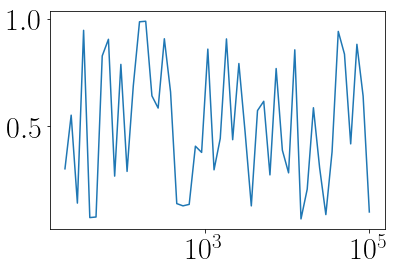

In [206]:
k = []
n = 10**(np.linspace(np.log10(20), np.log10(100000), 50))
for i in n:
    x = np.random.randn(int(i))
    k.append(sps.kurtosistest(x).pvalue)
plt.plot(n, k)
plt.xscale("log")
print(min(k))

At high b, there is just more noise? But at low b, Vz is slightly higher than Vb.

Low b -- more massive stars, more underestimated velocity dispersions?

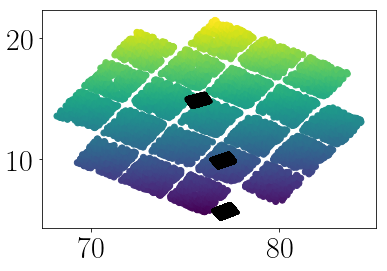

In [168]:
l_kepler, b_kepler = calc_lb(gaia_mc.ra.values, gaia_mc.dec.values)
plt.scatter(l_kepler, b_kepler, c=gaia_mc.b)
l, b = calc_lb(low_b.RAJ2000.values, low_b.DEJ2000.values)
plt.plot(l, b, "k.")
l, b = calc_lb(mid_b.RAJ2000.values, mid_b.DEJ2000.values)
plt.plot(l, b, "k.")
l, b = calc_lb(max_b.RAJ2000.values, max_b.DEJ2000.values)
plt.plot(l, b, "k.")

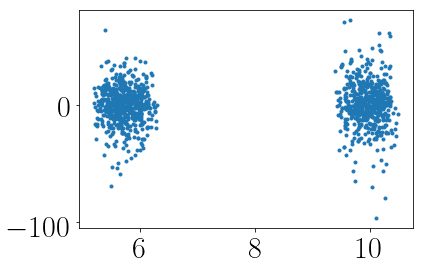

In [169]:
vb, vz, l, b = calc_vb_vz(df)
df["vz"] = vz
df["vb"] = vb
df["b"] = b
df["l"] = l

plt.plot(df.b, df.vz, ".")

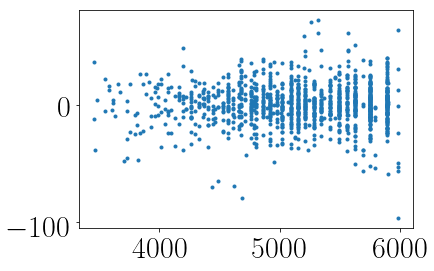

In [170]:
plt.plot(df.Teff, df.vz, ".")

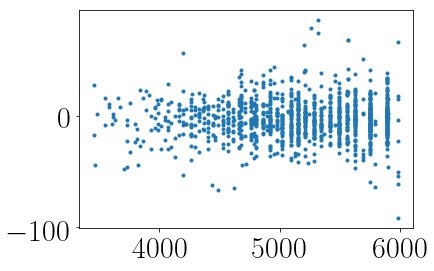

In [171]:
plt.plot(df.Teff, df.vb, ".")

0.0005195109855430036 +- 0.0006560309748476382
0.7919000862172079


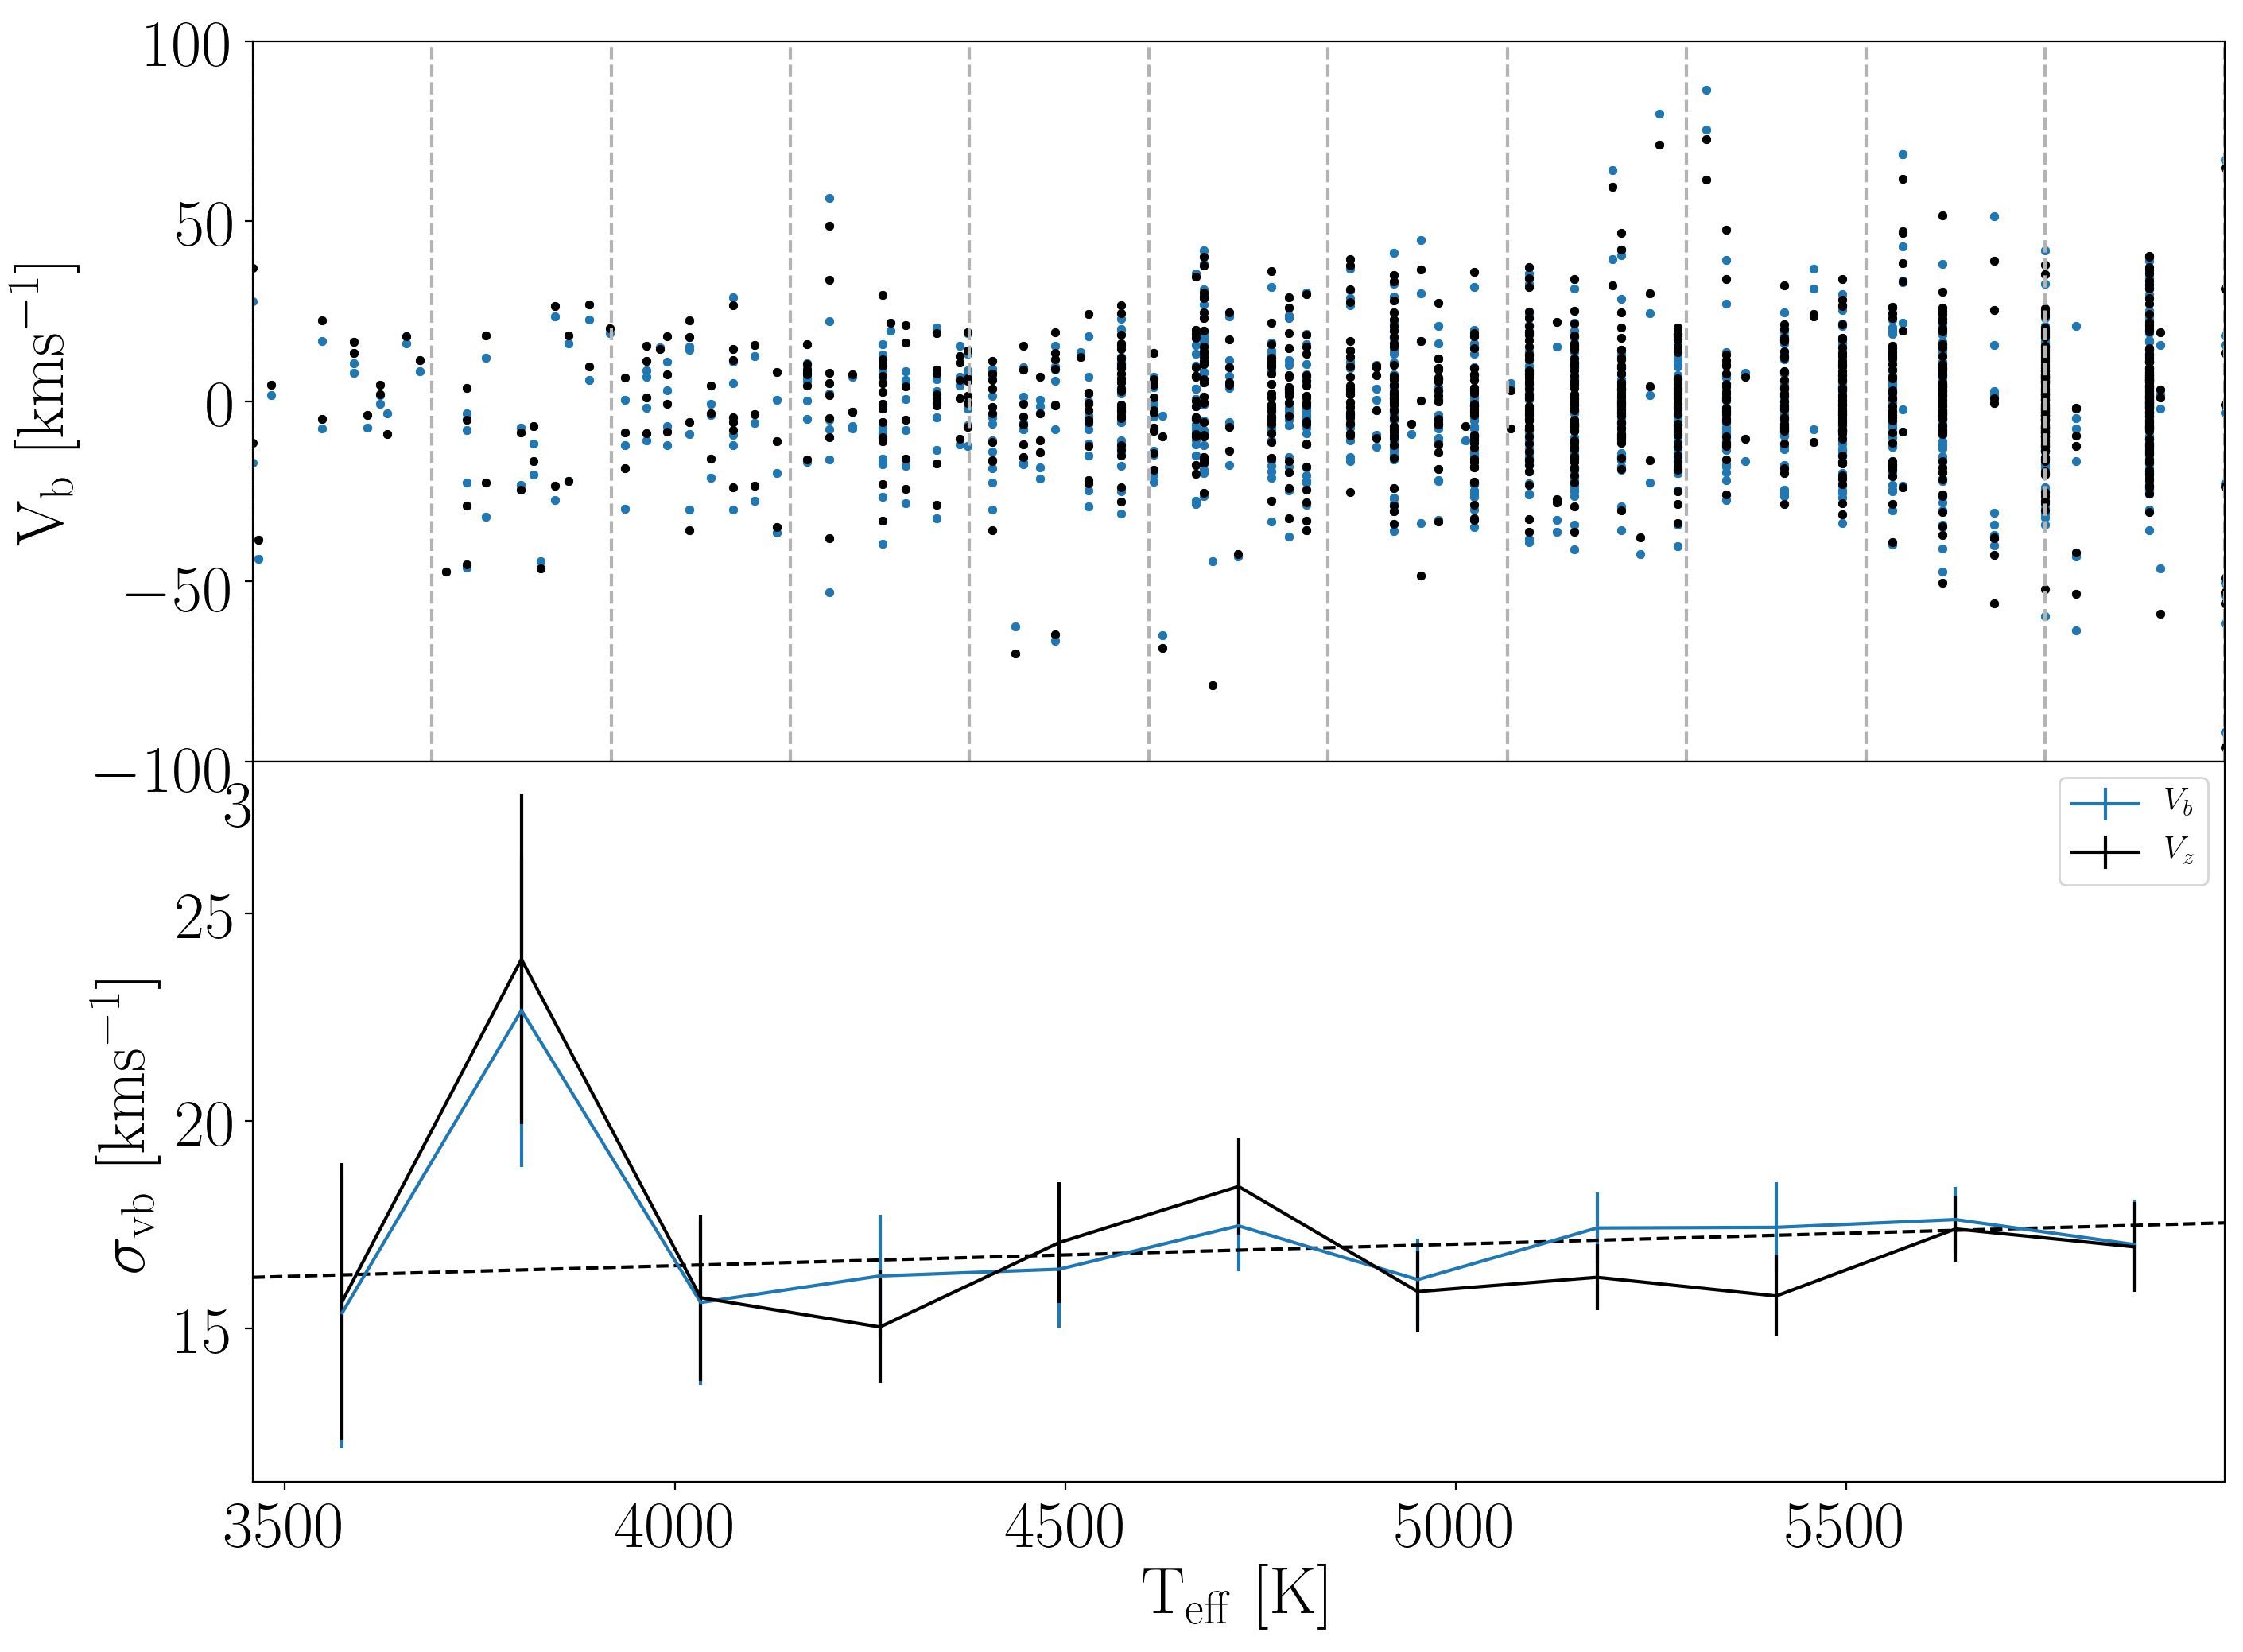

In [172]:
from dispersion import *

teff_bins = np.linspace(min(df.Teff), max(df.Teff), 12)
teff_masks = select_stars(df, teff_bins, "Teff")
mid_teff_bin = np.diff(teff_bins)*.5 + teff_bins[:-1]
b_bins = np.linspace(min(df.b), max(df.b))
b_masks = select_stars(df, b_bins, "b")
mid_b_bin = np.diff(b_bins)*.5 + b_bins[:-1]

vb = df.vb.values

# Top panel
fig = plt.figure(figsize=(16, 12), dpi=200)
ax1 = fig.add_subplot(211)
ax1.plot(df.Teff, df.vb, ".")
ax1.plot(df.Teff, df.vz, "k.")
ax1.set_xlim(min(df.Teff), max(df.Teff))

sigma_vb, sigma_vb_err = [], []
sigma_vz, sigma_vz_err = [], []
for i, m in enumerate(teff_masks):
    sigma_vb.append(np.std(df.vb.values[m]))
    sigma_vb_err.append(err_on_sample_std_dev(np.std(df.vb.values[m]), float(len(df.vb.values[m]))))
    ax1.plot(df.Teff[m], df.vb.values[m], "C0.")
    
    sigma_vz.append(np.std(df.vz.values[m]))
    sigma_vz_err.append(err_on_sample_std_dev(np.std(df.vz.values[m]), float(len(df.vz.values[m]))))
    ax1.plot(df.Teff[m], df.vz.values[m], "k.")
    
    ax1.axvline(teff_bins[i], color=".7", ls="--")
    
ax1.axvline(teff_bins[-1], color=".7", ls="--")

ax1.set_ylabel("$\mathrm{V_b~[kms^{-1}]}$")
plt.ylim(-100, 100)
    
# Bottom panel
ax2 = fig.add_subplot(212, sharex=ax1)

ax2.errorbar(mid_teff_bin, sigma_vb, yerr=sigma_vb_err, label="$V_b$")
ax2.errorbar(mid_teff_bin, sigma_vz, yerr=sigma_vz_err, fmt="k", label="$V_z$")

# Fit a line
w, Cw = fit_line(np.array(mid_teff_bin), np.array(sigma_vb), np.array(sigma_vb_err))
xs = np.linspace(min(df.Teff), max(df.Teff), 100)
plt.plot(xs, w[0] + w[1]*xs, "k--")
print(w[1], "+-", np.sqrt(Cw[1, 1]))
print(w[1]/np.sqrt(Cw[1, 1]))

ax2.legend()
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
plt.subplots_adjust(hspace=0)

/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan +- nan
nan


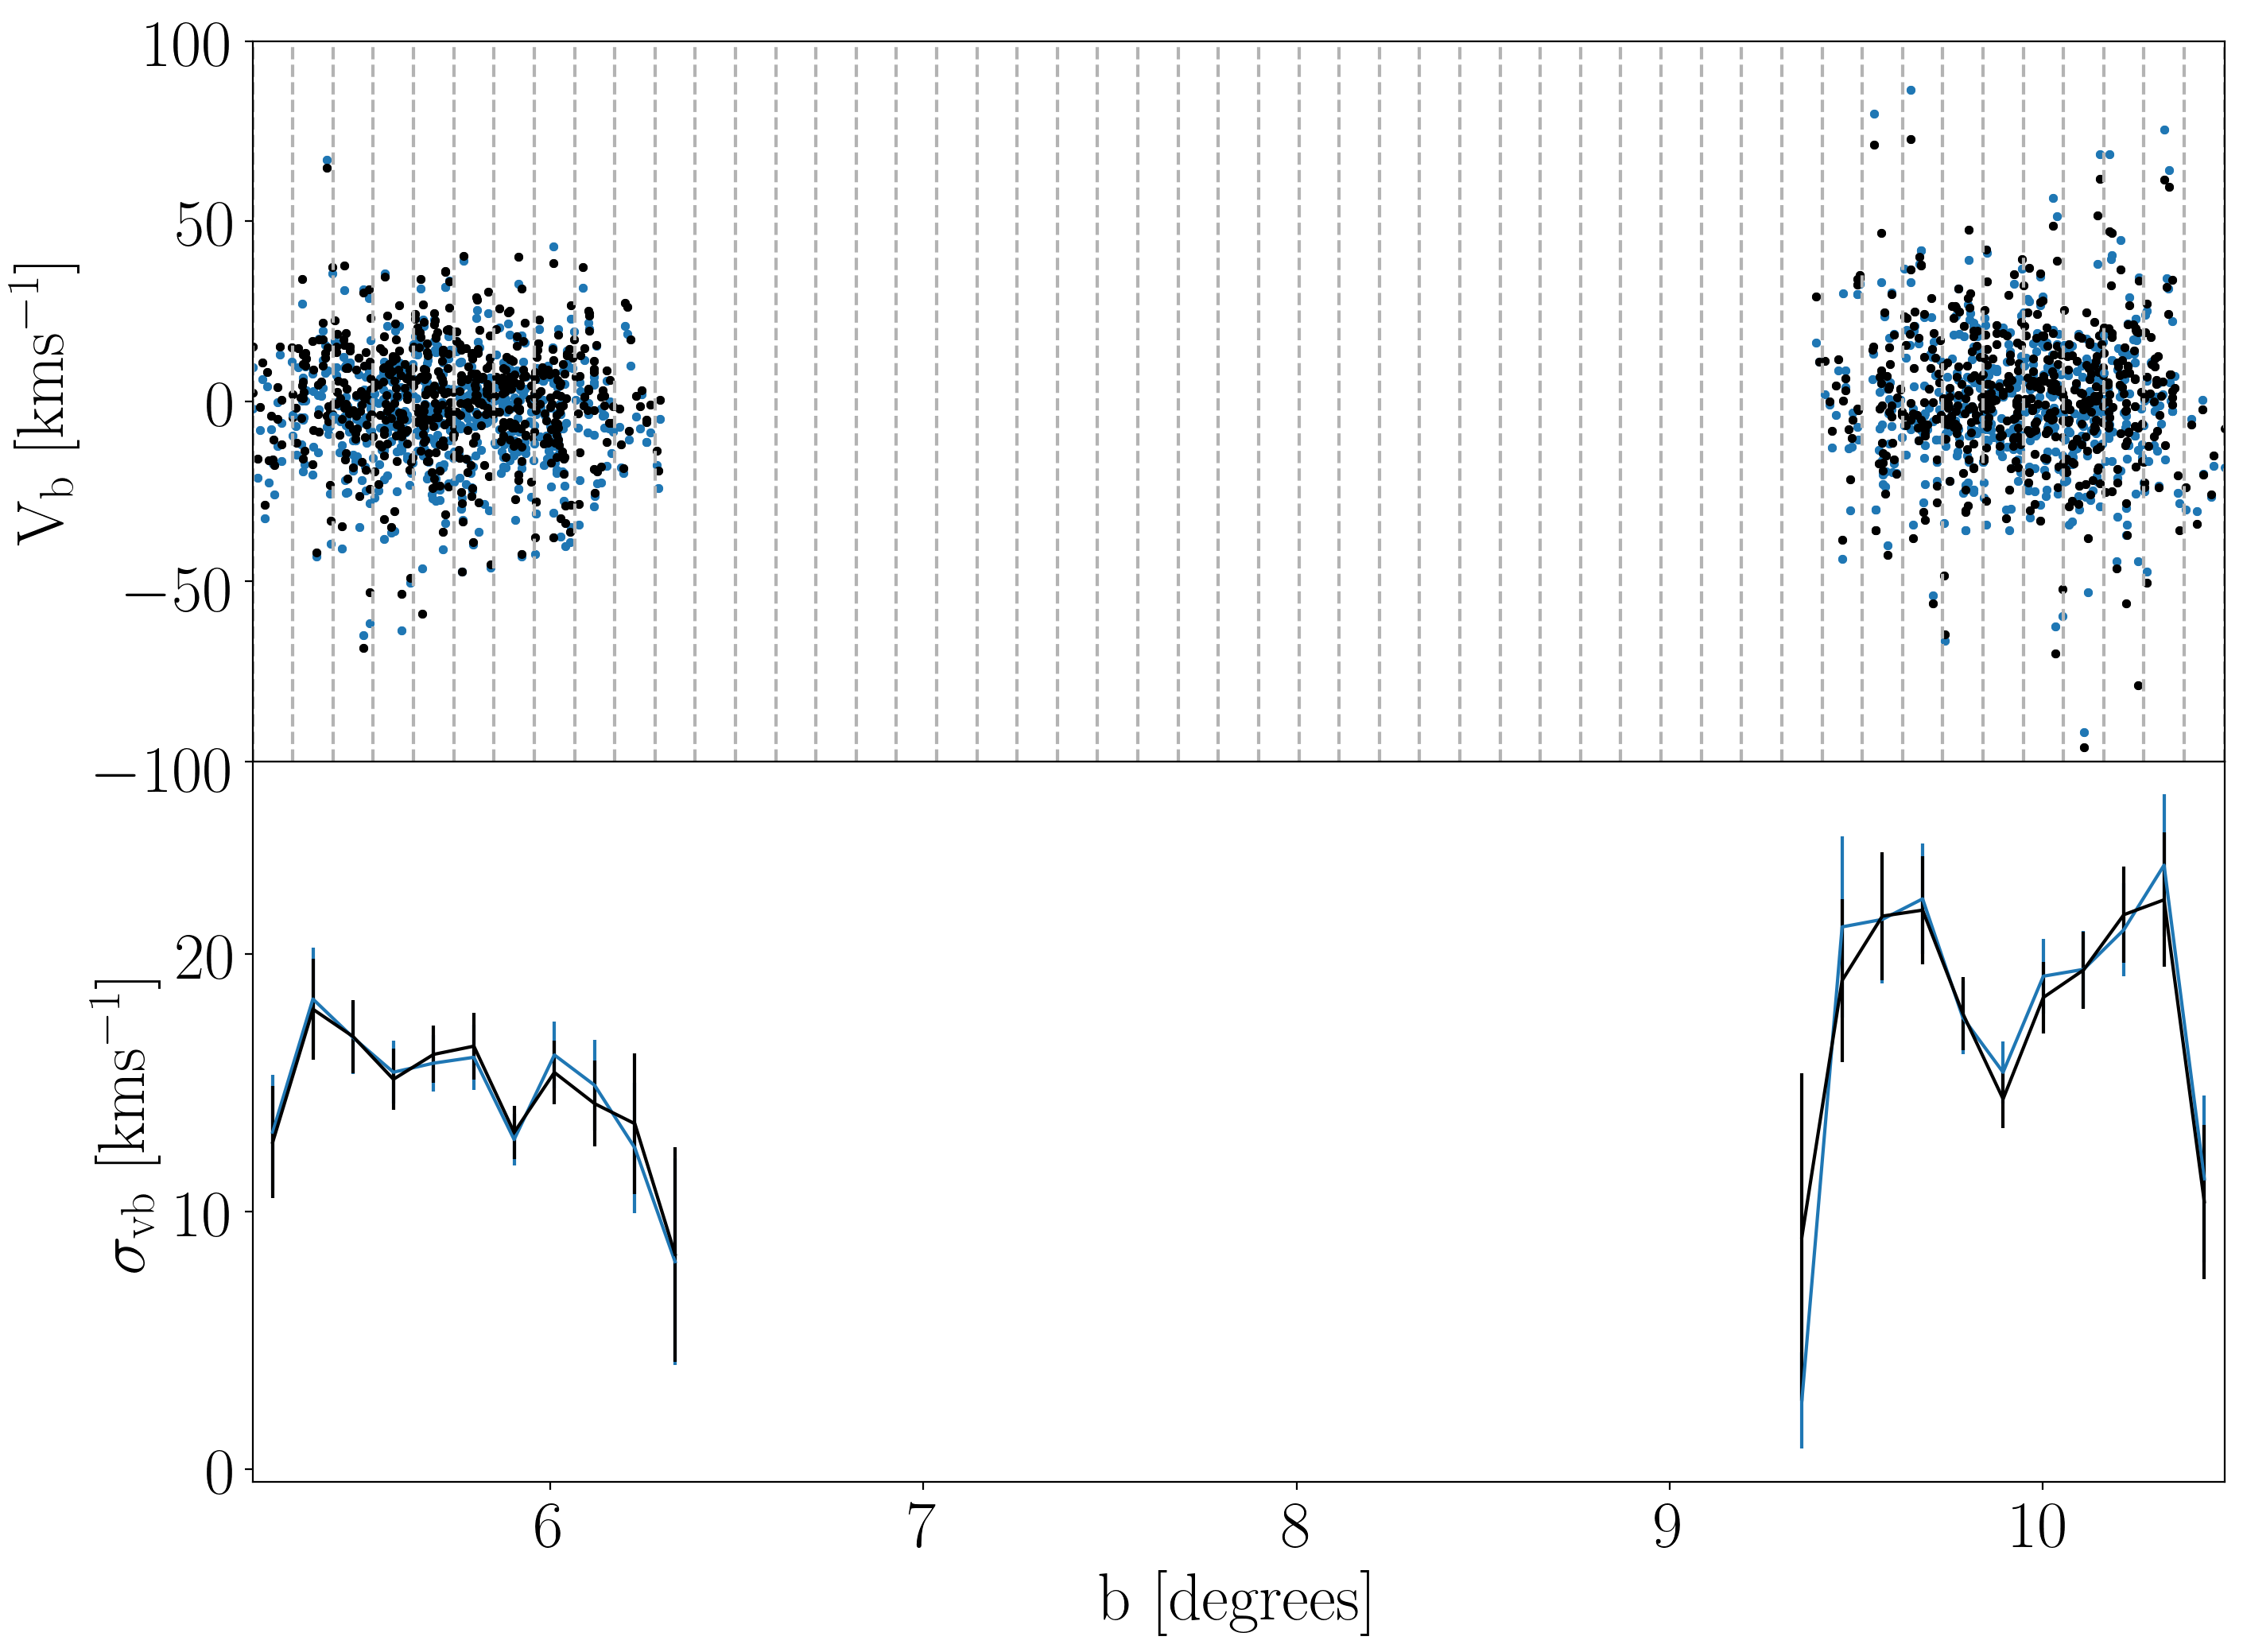

In [173]:
l, b = calc_lb(df.RAJ2000.values, df.DEJ2000.values)
df["b"] = b

# Top panel
fig = plt.figure(figsize=(16, 12), dpi=200)
ax1 = fig.add_subplot(211)
ax1.plot(df.b, df.vb, ".")
ax1.plot(df.b, df.vz, "k.")
ax1.set_xlim(min(df.b), max(df.b))

sigma_vb, sigma_vb_err = [], []
sigma_vz, sigma_vz_err = [], []
for i, m in enumerate(b_masks):
    sigma_vb.append(np.std(df.vb.values[m]))
    sigma_vb_err.append(err_on_sample_std_dev(np.std(df.vb.values[m]), float(len(df.vb.values[m]))))
    ax1.plot(df.b[m], df.vb.values[m], "C0.")
    
    sigma_vz.append(np.std(df.vz.values[m]))
    sigma_vz_err.append(err_on_sample_std_dev(np.std(df.vz.values[m]), float(len(df.vz.values[m]))))
    ax1.plot(df.b[m], df.vz.values[m], "k.")
    
    ax1.axvline(b_bins[i], color=".7", ls="--")
    
ax1.axvline(b_bins[-1], color=".7", ls="--")

ax1.set_ylabel("$\mathrm{V_b~[kms^{-1}]}$")
plt.ylim(-100, 100)
    
# Bottom panel
ax2 = fig.add_subplot(212, sharex=ax1)

ax2.errorbar(mid_b_bin, sigma_vb, yerr=sigma_vb_err)
ax2.errorbar(mid_b_bin, sigma_vz, yerr=sigma_vz_err, fmt="k")

# Fit a line
w, Cw = fit_line(np.array(mid_b_bin), np.array(sigma_vb), np.array(sigma_vb_err))
xs = np.linspace(min(df.b), max(df.b), 100)
plt.plot(xs, w[0] + w[1]*xs, "k--")
print(w[1], "+-", np.sqrt(Cw[1, 1]))
print(w[1]/np.sqrt(Cw[1, 1]))

ax2.set_xlabel("$\mathrm{b~[degrees]}$")
ax2.set_ylabel("$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
plt.subplots_adjust(hspace=0)

Next: download a bigger selection of stars, centered on the Kepler field. 

In [83]:
kg = pd.read_csv("kepler_GUMS.tsv", skiprows=68, delimiter=";")
kg.head()

,Pop,Gmag,GBmag,GRmag,Gsmag,RAJ2000,DEJ2000,r,pmRA,pmDE,RV,Mass,[Fe/H],Teff,logg,fI,Vtype
0,1,18.396,18.892,17.717,17.415,291.489600,44.002186,3450.9,-2.664,-4.529,-38.2,1.45,-0.10,0,0.00,0,NaN
1,1,18.471,18.934,17.824,17.536,291.489600,44.002186,3450.9,-2.664,-4.529,-28.4,0.87,-0.10,5152,4.52,0,NaN
2,1,21.328,22.309,20.292,19.822,291.489600,44.002186,3450.9,-2.664,-4.529,-51.9,0.58,-0.10,3864,4.74,0,NaN
3,1,18.941,19.809,17.973,17.536,291.651131,44.006690,1566.5,-2.796,-3.652,-31.5,0.66,0.03,4074,4.69,0,NaN
4,1,16.205,16.632,15.593,15.320,291.642428,44.002667,1511.2,-3.269,-7.859,-32.4,0.99,-0.08,5559,4.48,0,NaN


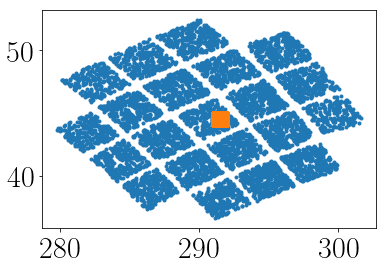

In [85]:
plt.plot(gaia_mc.ra, gaia_mc.dec, ".")
plt.plot(kg.RAJ2000, kg.DEJ2000, ".")